In [1]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import average_precision_score

import mlflow
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
# Set the MLflow tracking URI 
mlflow.set_tracking_uri("file:./mlruns")

# Set an experiment name 
mlflow.set_experiment("Spam_Detection")

2025/03/03 20:06:42 INFO mlflow.tracking.fluent: Experiment with name 'Spam_Detection' does not exist. Creating a new experiment.


<Experiment: artifact_location=('file:///d:/Education/CMI/4th '
 'Semester/AML/AppliedMachineLearning/Assignment_2/mlruns/282749747970365678'), creation_time=1741012602503, experiment_id='282749747970365678', last_update_time=1741012602503, lifecycle_stage='active', name='Spam_Detection', tags={}>

In [4]:
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')
val_data = pd.read_csv('validation.csv')

train_data = train_data.dropna()
test_data = test_data.dropna()
val_data = val_data.dropna()

# Vectorize text using TF-IDF
vectorizer = TfidfVectorizer(max_features=5000)
X_train = vectorizer.fit_transform(train_data['message'])
X_val = vectorizer.transform(val_data['message'])
X_test = vectorizer.transform(test_data['message'])

y_train, y_val, y_test = train_data['label'], val_data['label'], test_data['label']


In [5]:
def tune_hyperparameters(model, param_grid, X_train, y_train, X_val, y_val, test="Validation"):
    grid_search = GridSearchCV(model, param_grid, scoring='f1', cv=3, n_jobs=-1)
    grid_search.fit(X_train, y_train)
    
    best_model = grid_search.best_estimator_
    
    # Evaluate best model
    train_preds = best_model.predict(X_train)
    val_preds = best_model.predict(X_val)
    
    train_metrics = round(average_precision_score(y_train, train_preds), 3)
    val_metrics = round(average_precision_score(y_val, val_preds), 3)
    print(f'Best Parameters: {grid_search.best_params_}')
    print(f'Train Metrics: {train_metrics}')
    print(f'{test} Metrics: {val_metrics}')

    plt.figure(figsize=(6, 4))
    sns.barplot(x=['Train', test], y=[train_metrics, val_metrics], palette="Blues_r")

    plt.ylim(0, 1)
    plt.ylabel("AUCPR Score")
    plt.title(f"Train vs {test} AUCPR")
    plt.show()
    plt.show()

    return {"Train": train_metrics, test: val_metrics, 'Model': best_model, 'Params': grid_search.best_params_}


In [6]:
def validate_model(model, X_train, y_train, X_val, y_val, test="Validation"):
    model.fit(X_train, y_train)
    
    train_preds = model.predict(X_train)
    val_preds = model.predict(X_val)

    train_metrics = round(average_precision_score(y_train, train_preds), 3)
    val_metrics = round(average_precision_score(y_val, val_preds), 3)
    print(f'Train Metrics: {train_metrics}')
    print(f'{test} Metrics: {val_metrics}')

    plt.figure(figsize=(6, 4))
    sns.barplot(x=['Train', test], y=[train_metrics, val_metrics], palette="Blues_r")

    plt.ylim(0, 1)
    plt.ylabel("AUCPR Score")
    plt.title(f"Train vs {test} AUCPR")
    plt.show()


    return {"Train": train_metrics, test: val_metrics}

### Validation Dataset

Training Logistic_Regression
Train Metrics: 0.684
Validation Metrics: 0.731


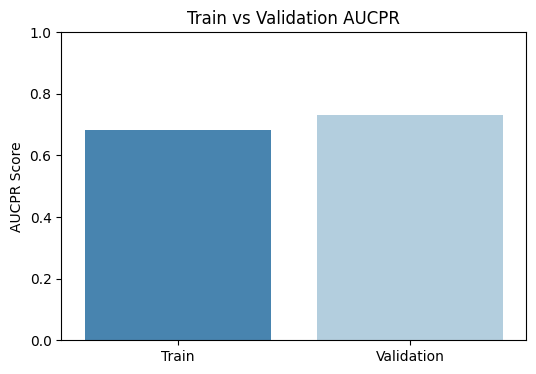

2025/03/03 20:06:50 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Successfully registered model 'Logistic_Regression'.
Created version '1' of model 'Logistic_Regression'.


Training Random_Forest
Train Metrics: 0.998
Validation Metrics: 0.821


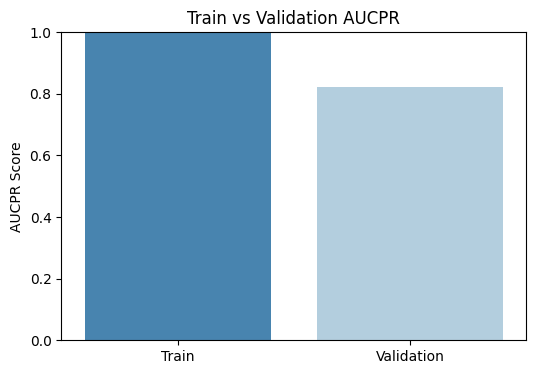

2025/03/03 20:06:56 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Successfully registered model 'Random_Forest'.
Created version '1' of model 'Random_Forest'.


Training Naive_Bayes
Train Metrics: 0.8
Validation Metrics: 0.641


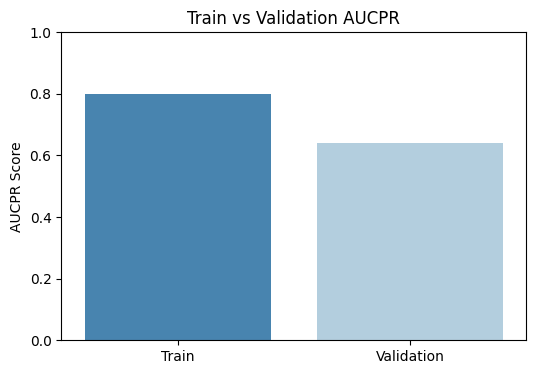

2025/03/03 20:07:01 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Successfully registered model 'Naive_Bayes'.
Created version '1' of model 'Naive_Bayes'.


In [7]:
models = {
    "Logistic_Regression": LogisticRegression(),
    "Random_Forest": RandomForestClassifier(),
    "Naive_Bayes": MultinomialNB()
}


for name, model in models.items():
    with mlflow.start_run(run_name=f'{name}_val'):
        print(f"Training {name}")
        scores = validate_model(model, X_train, y_train, X_val, y_val)
        mlflow.log_param("model_type", name)
        mlflow.log_metric("Train_AUCPR", scores['Train'])
        mlflow.log_metric("Validation_AUCPR", scores['Validation'])

        mlflow.sklearn.log_model(model, name)
        mlflow.register_model(f"runs:/{mlflow.active_run().info.run_id}/{name}_val", name)

### Hyperparameter Tuning

Training Logistic_Regression
Best Parameters: {'C': 100, 'penalty': 'l2', 'solver': 'lbfgs'}
Train Metrics: 0.998
Validation Metrics: 0.801


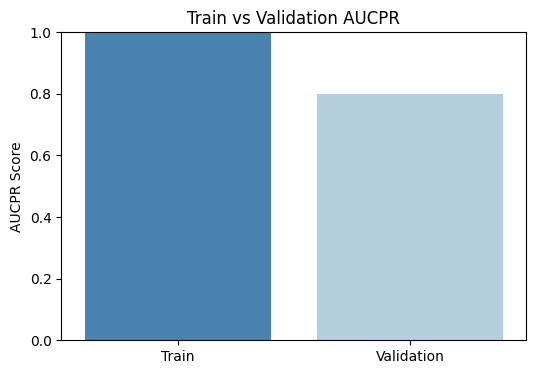

2025/03/03 20:07:11 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Successfully registered model 'Logistic_Regression_val_tuned'.
Created version '1' of model 'Logistic_Regression_val_tuned'.


Training Random_Forest
Best Parameters: {'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
Train Metrics: 0.998
Validation Metrics: 0.856


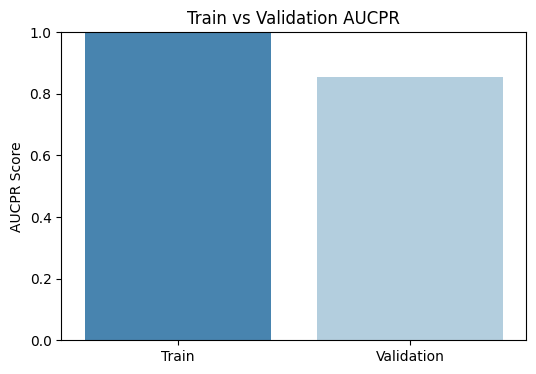

2025/03/03 20:09:40 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Successfully registered model 'Random_Forest_val_tuned'.
Created version '1' of model 'Random_Forest_val_tuned'.


Training Naive_Bayes
Best Parameters: {'alpha': 0.1, 'fit_prior': True}
Train Metrics: 0.962
Validation Metrics: 0.783


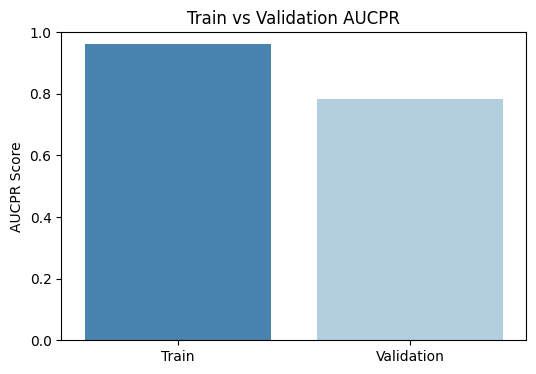

2025/03/03 20:09:45 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Successfully registered model 'Naive_Bayes_val_tuned'.
Created version '1' of model 'Naive_Bayes_val_tuned'.


In [8]:
models = {
    "Logistic_Regression": LogisticRegression(),
    "Random_Forest": RandomForestClassifier(),
    "Naive_Bayes": MultinomialNB()
}

hyperparameters = {
    "Logistic_Regression": {
    'C': [0.01, 0.1, 1, 10, 100], 
    'penalty': ['l2'],  
    'solver': ['liblinear', 'lbfgs']  
    },

    "Random_Forest": {
    'n_estimators': [50, 100, 200], 
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],  
    'bootstrap': [True, False]  
    },

    "Naive_Bayes": {
    'alpha': [0.01, 0.1, 1, 10],  # Smoothing parameter
    'fit_prior': [True, False]  # Whether to learn class priors
    }
}



for name, model in models.items():
    print(f"Training {name}")
    with mlflow.start_run(run_name=f'{name}_val_tuned'):
        scores = tune_hyperparameters(model, hyperparameters[name], X_train, y_train, X_val, y_val)
        mlflow.log_param("model_type", name)
        mlflow.log_metric("Train_AUCPR", scores['Train'])
        mlflow.log_metric("Validation_AUCPR", scores['Validation'])

        mlflow.sklearn.log_model(scores['Model'], name)
        mlflow.register_model(f"runs:/{mlflow.active_run().info.run_id}/{name}_val_tuned", f'{name}_val_tuned')

### Test Dataset

In [ ]:
model = mlflow.sklearn.load_model("models:/Random_Forest/latest")
y_pred = model.predict(X_test)
score = round(average_precision_score(y_test, y_pred), 3)
print(f'AUPCR score on test dataset: {score}')